# Correction (François Portier et Pierre Laforgue)

In [2]:
import numpy as np
import pandas as pd

from scipy.stats import norm

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.svm import SVR

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib notebook

np.random.seed(2)

# Q1 : Importer la base de données "data_dm3.csv".
La base de données est disponible sur le site pédagogique. La dernière colonne est la variable à expliquer. Les autres colonnes sont les variables explicatives. Préciser le nombre de variables explicatives et le nombre d'observations.

In [4]:
df = pd.read_csv('https://bitbucket.org/portierf/shared_files/downloads/data_dm3.csv', header=None)
A = np.array(df)
print(A.shape)

X = A[:, :-1]          # on récupère les covariables
Y = A[:, -1]           # puis l'output

n, d = X.shape
print("La dimension de la matrice X est: %s x %s" % (n, d))

(442, 211)
La dimension de la matrice X est: 442 x 210


# Q2 : Les variables explicatives
sont-elles centrées? Normalisées? Qu'en est-il de la variable à expliquer?
Tracer un scatter plot de la base de données avec 4 covariables prises au hasard et la variable à expliquer (un scatterplot regroupe les graphes de chacune des variables en fonction de chacune des autres). Commenter les graphiques obtenus.

In [5]:
print("Afin de s'assurer que l'on calcule les moyennes et les variances pour",
      "les bonnes variables,\non regarde si les tailles coincident. C'est %s avec axis=0, %s avec axis=1.\n"
      % (len(X.mean(axis=0)) == d, len(X.mean(axis=1)) == d))

print("Les variables explicatives sont-elles:\n centrées? %s\n réduites? %s\n"
      % (np.allclose(X.mean(axis=0), 0), np.allclose(X.std(axis=0), 1)))

print("La variable à expliquer est-elle \n centrée? %s\n réduite? %s"
      % (np.allclose(Y.mean(axis=0), 0), np.allclose(Y.std(axis=0), 1)))

Afin de s'assurer que l'on calcule les moyennes et les variances pour les bonnes variables,
on regarde si les tailles coincident. C'est True avec axis=0, False avec axis=1.

Les variables explicatives sont-elles:
 centrées? True
 réduites? True

La variable à expliquer est-elle 
 centrée? False
 réduite? False


Chaque variable de X est centrée et normalisée, mais pas Y. Maintenant on fait les scatterplots.

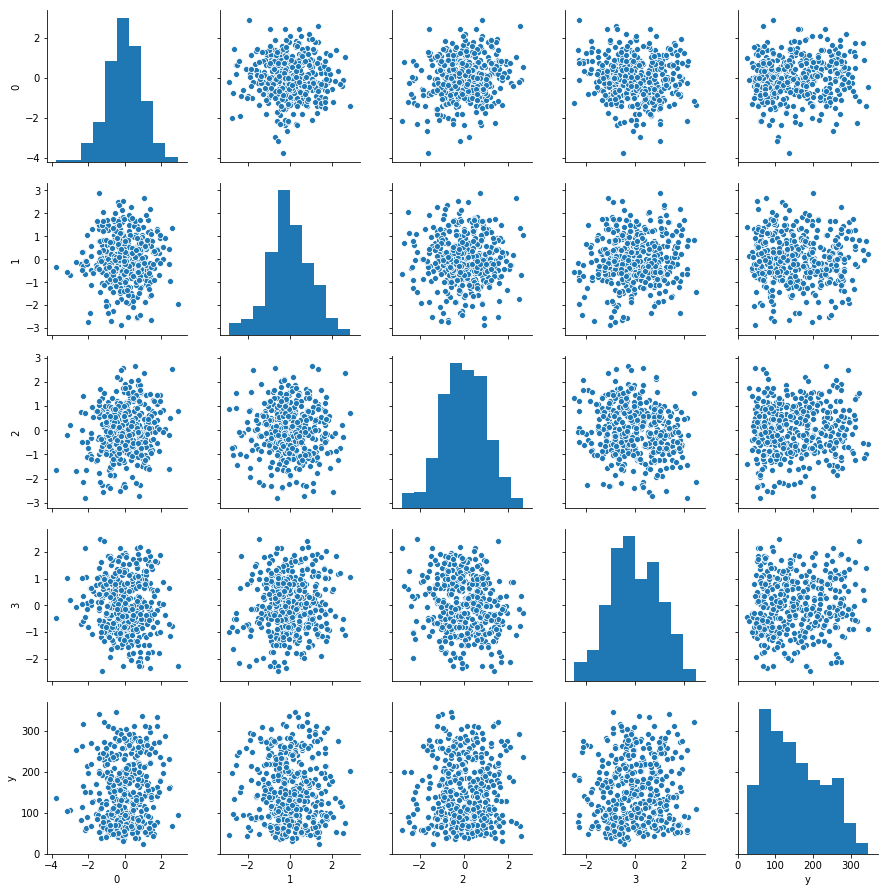

In [6]:
#sns.set(style="ticks")
df_sub = pd.DataFrame(X[:, np.random.choice(range(210), 4)])
df_sub['y'] = Y

sns.pairplot(df_sub)
plt.show()

Commentaire attendu : Les covariables séléctionées semblent peu corrélées entre elle. Elles sont aussi peu corrélées avec la variable explicative. Ceci témoigne de la présence de sparsité dans les données.

# Q3: Echantillon d'apprentissage et de test.

Créer 2 echantillons : un pour apprendre le modèle, un pour tester le modèle. On mettra 20% de la base dans l'échantillon 'test'. Donner les tailles de chacun des 2 échantillons.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
n_train, _ = X_train.shape
print(X_train.shape, X_test.shape)

(353, 210) (89, 210)


Dans la suite, on ne centre pas les covariables. On fera donc bien attention à inclure l'intercept dans les régressions. On pouvait aussi choisir de les centrer-réduires. 

# Q4 : Donner la matrice des correlations.
Tracer le graphe de la décroissance des valeurs propores de la matrix de covariance. Expliquer pourquoi il est légitime de ne garder que les premières variables de l'ACP. On gardera $60$ variables dans la suite.

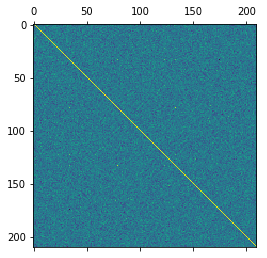

In [8]:
df = pd.DataFrame(X_train)
COV = df.cov()
plt.matshow(COV)
plt.show()

Calculons la svd de la matrice de covariance (ici, on pouvait aussi bien utiliser la décompostion spéctrale classique, et non la SVD): 

In [9]:
U, s, V = np.linalg.svd(COV, full_matrices = True)

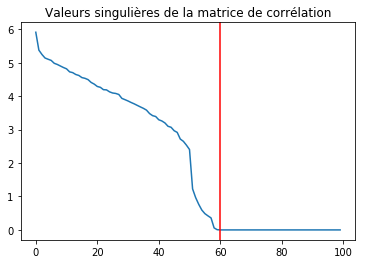

In [10]:
fig = plt.figure()
plt.plot(s[0: 100])
plt.axvline(60, c='r')
plt.title("Valeurs singulières de la matrice de corrélation")
plt.show()

On remarque que seulement les 51 premières valeurs sont (significativement) différentes de 0. Ceci veut dire que la matrice de design est de rang déficient (51 < 210). Ainsi tenter une statégie de type ''PCA before OLS'' est légitime. On enregistre l'indice de la dernière valeur propre non-nulle.

In [11]:
elbow = 60   

# Q5 : PCA before OLS

Suivant les observations de la question Q3, appliquer la méthode de "PCA before OLS" qui consiste à faire une ACP avant la régression. On tracera les valeurs des coefficients de regression calculés (sans l'intercept). Sur un autre graphique, faire de même avec la méthode des moindres carrées classique.

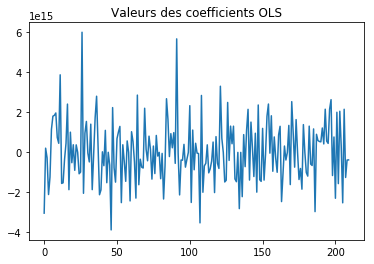

In [12]:
regr0 = LinearRegression()
regr0.fit(X_train, y_train)

fig = plt.figure()
plt.plot(regr0.coef_)
plt.title("Valeurs des coefficients OLS")
plt.show()

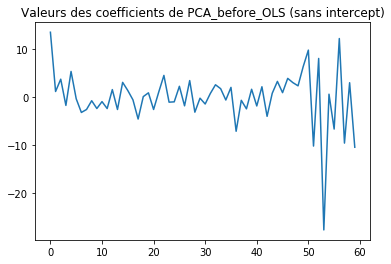

In [13]:
X_train_reduce = np.dot(X_train, U[:, :elbow])
X_test_reduce = np.dot(X_test, U[:, :elbow])

regr1 = LinearRegression()
regr1.fit(X_train_reduce, y_train)

fig = plt.figure()
plt.plot(regr1.coef_)
plt.title("Valeurs des coefficients de PCA_before_OLS (sans intercept)")
plt.show()

# Q6 : Donner les valeurs des intercepts
pour les $2$ regressions précédentes. Donner la valeur moyenne de la variable $Y_{\text{train}}$. Les intercepts des 2 questions sont-ils égaux? Commenter. 
Centrer et réduire les variables après ACP (de petite dimension). Faire une régression avec ces variables et vérifier que l'intercept est bien égal à la moyenne de $Y_{\text{train}}$.

In [14]:
for y in (regr0.intercept_, regr1.intercept_, y_train.mean(axis=0)):
    print("%.3f" % y)

print("\nLes deux intercepts sont-ils égaux: %s"
      % np.isclose(regr0.intercept_, regr1.intercept_))

153.753
152.180
153.003

Les deux intercepts sont-ils égaux: False


Commentaire attendu : Les 2 valeurs sont différentes. On a vu en cours que si les variables $X$ sont centrées alors l'intercept est égal à la valeur moyenne de $Y$. Ici les variables $X$ (tout l'échantillon) sont centrées mais pas les variables $X_{\text{train}}$. C'est pour cette raison que la régression sur $X_{\text{train}}$ donne un intercept différent de la moyenne sur $ Y_{\text{train}}$.

In [15]:
X_train_reduce2 = preprocessing.scale(X_train_reduce)

regrtest = LinearRegression()
regrtest.fit(X_train_reduce2, y_train)

print("On vérifie l'égalité. Cette égalité est: %s."
      % np.isclose(regrtest.intercept_, np.mean(y_train)))

On vérifie l'égalité. Cette égalité est: True.


# Q7 : PCA before OLS

Pour les 2 méthodes :  Tracer les résidus de la prédiction sur l'échantillon test. Tracer leur densité (on pourra utiliser un histogramme). Calculer le coefficient de determination sur l'échantillon test. Caluler le risque de prédiction sur l'échantillon test.

In [16]:
R20 = regr0.score(X_test, y_test) 
R21 = regr1.score(X_test_reduce, y_test)

def MSE(y_pred, y_true):
    return np.mean((y_pred - y_true) ** 2)

pred_error0 = MSE(regr0.predict(X_test), y_test)
pred_error1 = MSE(regr1.predict(X_test_reduce), y_test)

print("Le R2 de OLS:            %.3f" % R20)
print("Le R2 de PCA before OLS: %.3f\n" % R21)
print("Le rique de prédiction de OLS calculé sur l'échantillon test:            %.2f" % pred_error0)
print("Le rique de prédiction de PCA before OLS calculé sur l'échantillon test: %.2f" % pred_error1)

Le R2 de OLS:            0.256
Le R2 de PCA before OLS: 0.360

Le rique de prédiction de OLS calculé sur l'échantillon test:            4178.05
Le rique de prédiction de PCA before OLS calculé sur l'échantillon test: 3591.96


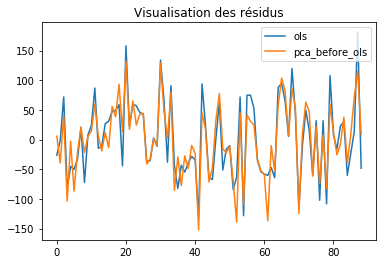

In [17]:
eps0 = regr0.predict(X_test) - y_test
eps1 = regr1.predict(X_test_reduce) - y_test

plt.figure()
plt.plot(eps0, label="ols")
plt.plot(eps1, label="pca_before_ols")
plt.legend(loc=1)
plt.title("Visualisation des résidus")
plt.show()

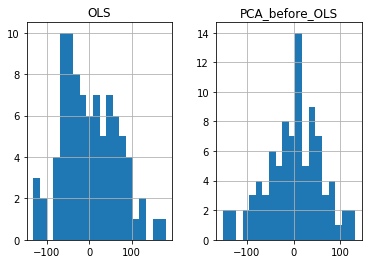

In [18]:
eps = pd.DataFrame(np.c_[eps0, eps1], columns=['OLS', 'PCA_before_OLS'])
eps.hist(bins=20)
plt.show()

En général, la méthode de l'ACP apporte quelques améliorations par rapport à OLS. Mais cela dépend de l'échantillon test choisi (aléatoire). Il peut arrivé (mais c'est rare ici) que l'ACP perde de l'information et entraine une prédiction plus faible.

# Q8 : Appliquer la méthode de forward variable selection.
On pourra par exemple choisir la statistique du test de nullité du coefficient. Pour l'instant, on ne met pas de critère d'arret sur la méthode. C'est à dire que l'on ajoute une variable à chaque étape jusqu'à retrouver la totalité des variables. Afficher l'ordre de séléction des variables.

Dans la suite on applique FORWARD parmi les variables explicatives. Chaque regression est faite avec 1 intercept 
et une des variables explicatives. A chaque regression on sauvegarde un score qui sera ensuite comparé aux autres.

In [19]:
resids = y_train

test = np.zeros((d, d))
pval_mem = np.zeros(d)
pval = np.zeros((d, d))
var_sel = []
var_remain = list(range(d))
in_test = []
 
regr = LinearRegression()

In [20]:
for k in range(d): 
    resids_mem = np.zeros((d, n_train))

    for i in var_remain:
        xtmp = X_train[:, [i]]
        regr.fit(xtmp, resids)
        
        # calcul de (x'x)
        xx = np.sum(X_train[:, i] ** 2)
        resids_mem[i, :] = regr.predict(xtmp) - resids
        sigma2_tmp = np.sum(resids_mem[i, :] ** 2) / xx
        test[k, i] = np.sqrt(n) * np.abs(regr.coef_) / (np.sqrt(sigma2_tmp))
        pval[k, i] = 2 * (1 - norm.cdf(test[k, i]))

    # separe en deux vecteurs la listes des variables séléctionnées et les autres
    best_var = np.argmax(test[k, :])
    var_sel.append(best_var)
    resids = resids_mem[best_var, :]
    pval_mem[k] = pval[k, best_var]
    var_remain = np.setdiff1d(var_remain, var_sel)

print("Voici l'ordre dans lequel les variables sont sélectionées par la méthode forward :\n\n%s" % var_sel)

Voici l'ordre dans lequel les variables sont sélectionées par la méthode forward :

[123, 58, 133, 167, 112, 135, 49, 129, 171, 93, 115, 5, 86, 180, 113, 159, 114, 21, 187, 203, 157, 99, 122, 174, 13, 78, 61, 138, 57, 79, 23, 127, 202, 205, 38, 141, 43, 151, 80, 40, 65, 36, 207, 172, 90, 82, 77, 35, 8, 124, 176, 84, 194, 10, 131, 204, 1, 117, 62, 177, 95, 178, 155, 75, 89, 34, 30, 107, 81, 6, 11, 145, 166, 161, 142, 59, 47, 18, 72, 29, 56, 119, 51, 4, 20, 137, 41, 111, 147, 25, 136, 125, 181, 0, 170, 53, 163, 193, 152, 97, 175, 116, 33, 192, 126, 3, 32, 52, 12, 206, 74, 199, 208, 102, 39, 109, 143, 183, 96, 190, 16, 60, 189, 91, 22, 168, 198, 132, 37, 98, 66, 140, 184, 76, 201, 195, 101, 110, 182, 54, 121, 186, 165, 50, 92, 149, 83, 104, 179, 197, 105, 85, 27, 94, 162, 185, 24, 87, 19, 128, 146, 9, 55, 156, 31, 73, 64, 28, 26, 188, 139, 173, 150, 103, 191, 134, 17, 14, 45, 71, 42, 106, 196, 15, 69, 63, 7, 118, 67, 158, 2, 209, 88, 68, 120, 164, 144, 48, 169, 130, 160, 46, 108, 200, 70,

# Q9 : Critère d'arrêt
On décide d'arreter lorsque la p-valeur  dépasse $.1$. Illustrer la méthode en donnant (i) les $3$ graphes des statistiques obtenues lors de la selection de la 1er, 2eme et 3eme variables, (ii) le graphe des $50$ premières pvaleurs (dont chacune est associée à la variable séléctionée). Sur ce même graphe, on tracera la ligne horizontale : $.1$. Enfin on donnera la liste des variables selectionées.

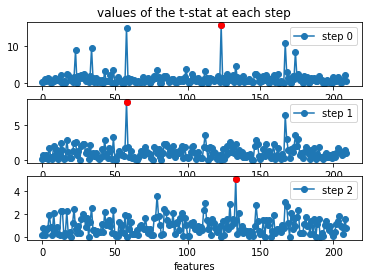

In [21]:
fig = plt.figure()

for k in range(3):
    
    plt.subplot(311 + k)
    
    if k == 0:
        plt.title("values of the t-stat at each step")

    plt.plot(np.arange(d), test[k, :], '-o', label="step %s" % k)
    plt.plot(var_sel[k], test[k, var_sel[k]], 'r-o')
    plt.legend(loc=1)
    
    if k == 2:
        plt.xlabel("features")

plt.show()

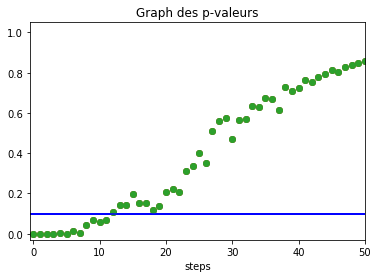

In [22]:
fig2 = plt.figure()

for k in range(3): 
    plt.plot(np.arange(d), pval_mem, 'o')
    plt.plot([-0.5, 50], [.1, .1], color="b")
    plt.axis(xmin=-.5, xmax=50, ymin=-.03)

plt.title("Graph des p-valeurs")
plt.xlabel("steps")
plt.show()

In [23]:
var_sel_a = np.array(var_sel)
#print(var_sel_a,var_sel)
var_sel_def = var_sel_a[pval_mem < 0.1]

print("Il y a donc %s variables selectionnées.\nLes voici: %s" % (len(var_sel_def), var_sel_def))

Il y a donc 12 variables selectionnées.
Les voici: [123  58 133 167 112 135  49 129 171  93 115   5]


# Q10 : Appliquer OLS sur les variables selectionées.

In [24]:
X_train_sel = X_train[:, var_sel_def]
X_test_sel = X_test[:, var_sel_def]

regr2 = LinearRegression()
regr2.fit(X_train_sel, y_train)

print(regr2.coef_)
print(regr2.intercept_)

[ 36.58151477  23.38466305 -11.76586783  15.1272309    8.02877434
  -7.3434079   -7.57770171  -6.9878753    3.7408956    6.7077053
   6.35787356   5.66792312]
151.32008886524767


In [25]:
pred_error_forward = MSE(regr2.predict(X_test_sel), y_test)

In [26]:
print("A titre de rappel, donnons les scores de prédiction obtenus précédemment.\n")

for method, error in zip(["ols           ", "pca_before_ols", "forward       "],
                         [pred_error0, pred_error1, pred_error_forward]):
    print(method + " : %.2f" % error)

A titre de rappel, donnons les scores de prédiction obtenus précédemment.

ols            : 4178.05
pca_before_ols : 3591.96
forward        : 3404.80


# Q11 : Afin de préparer la validation croisée,
séparer l'échantillon train en 4 parties (appelées ''folds'') de façon aléatoire. On affichera les numéros d'échantillon sélectionés.

In [27]:
np.random.seed(2)
perm = np.random.permutation(range(n_train))
q = n_train / 4.
split = np.array([0, 1, 2, 3, 4]) * q
split = split.astype(int)

for fold in range(4):
    print("La fold %s contient:\n%s\n\n" % (fold, perm[split[fold]: split[fold + 1]]))

La fold 0 contient:
[ 25 225 241 268 232 320 325  84  69  68  20  24 217  77 188   7 215 244
 234 306 269 264 351 210 180 157  55 161 308 172 146 156 147  17  30  89
 276 199 189 169   3 153 192  70 152 298 236 100 160 114 150 206  12  13
  67 131  98  66 163  29  65 257 126 151 345 174 128  35 240 342  10 305
 262  99 291 340 223 216 285  94 341 251 230  60 142 346 112 227]


La fold 1 contient:
[ 41  11 281 109  53 178 127 175 294 314 200 209   2 141 118 270  74 329
 106  91 204 292 286 186  23  28 190 173 212 166 237  39 336 214 331 278
 296 203 198 176  54   4 104 275 205  85   6 182 170 265 300  71 179 328
  87  64  14 303 339  18 272 181 284 310 103 183 154 261 120 317 144 184
  44 113 134 140  93 101 133   5 194 130  79 155 115 220 243 117]


La fold 2 contient:
[337 309 193 332 242 333  90 301 334 164 282   9  37 350  45 274 307 289
 349  36  48  42 335 159  57 165 145 122 221 105 318 253 258 273 197 228
   1 139 111 324 290 107   8 283 330 259 321 191 322  21 226 327 171 277
 

# Q12 : Appliquer la méthode de la régression ridge.
Pour le choix du paramètre de régularisation, on fera une validation croisée sur les ''folds'' définies lors de la question précédente. A tour de role chacune des ''folds'' servira pour calculer le risque de prédiction alors que les autres seront utilisées pour estimer le modèle. On moyennera ensuite les $4$ risques de prédictions. On donnera la courbe du risque de validation croisée en fonction du paramètre de régularisation. Donner le paramêtre de régularisation optimal et la valeur du risque sur le test.

In [28]:
clf = Ridge()
mem_score = []
alphas = np.logspace(-3, 2, 30)

for alphatest in alphas:
    mem_score_alph = []
    for k in range(4):
        clf.set_params(alpha = alphatest)
        te = perm[split[k]: split[k + 1]]
        tr = np.delete(perm, te, 0)
        clf.fit(X_train[tr, :], y_train[tr])
        mem_score_alph.append(MSE(clf.predict(X_train[te, :]), y_train[te]))
    mem_score.append(np.mean(mem_score_alph))

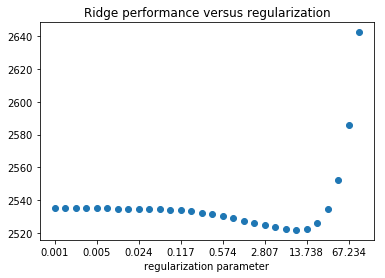

In [29]:
np.set_printoptions(precision=2)
fig3 = plt.figure()
plt.plot(mem_score, 'o')
plt.title("Ridge performance versus regularization")
plt.xticks(np.arange(30)[::4], ["%.3f" % alpha for alpha in alphas[::4]])
plt.xlabel("regularization parameter")
plt.show()

Il est possible que le graphique soit moins parlant que celui obtenu ici (ça dépend de la graine) et que la valeur de lambda soit 0. 

In [30]:
clf = Ridge()
l = np.argmin(mem_score)
clf.set_params(alpha=alphas[l])
clf.fit(X_train, y_train)
pred_error_ridge = MSE(clf.predict(X_test), y_test)

In [31]:
print("Le paramètre de régularisation choisi est: %.2f" % alphas[l])
print("L'erreur (quadratique) de prédiction sur le test est: %.2f" % pred_error_ridge)

Le paramètre de régularisation choisi est: 9.24
L'erreur (quadratique) de prédiction sur le test est: 3598.56


# Q13 : LASSO
A l'aide de la fonction lassoCV de sklearn, choisir le parametre de régularisation du LASSO. Donner le rique de prédiction calculé sur le test. Le comparer aux autres.

In [32]:
lasso = LassoCV()
lasso.fit(X_train, y_train)

# The estimator chose automatically its lambda:
lasso.alpha_

6.5039176074293765

In [33]:
pred_error_lasso = MSE(lasso.predict(X_test), y_test)

In [34]:
print("A titre de rappel, donnons les scores obtenus précédement.\n")

for method, error in zip(["ols           ", "pca_before_ols", "forward       ",
                          "ridge         ", "lasso         "],
                         [pred_error0, pred_error1, pred_error_forward,
                          pred_error_ridge, pred_error_lasso]):
    print(method + " : %.2f" % error)

A titre de rappel, donnons les scores obtenus précédement.

ols            : 4178.05
pca_before_ols : 3591.96
forward        : 3404.80
ridge          : 3598.56
lasso          : 3184.74


# Q14 : Donner les variables selectionées par le lasso. 
Combien y-en a t-il? Appliquer la méthode LASSO + OLS (aussi appelé Least-square LASSO).

In [35]:
print("Le LASSO séléctionne %s variables" % np.sum(lasso.coef_ > 0 ))

X_train_sel_lasso = X_train[:, lasso.coef_ > 0 ]
X_test_sel_lasso = X_test[:, lasso.coef_ > 0]

regr2Lasso = LinearRegression()
regr2Lasso.fit(X_train_sel_lasso, y_train)

pred_error_LSLASSO = MSE(regr2Lasso.predict(X_test_sel_lasso), y_test)

print("Voici les scores obtenus :\n"),

for method, error in zip(["ols           ", "pca_before_ols", "forward       ",
                          "ridge         ", "lasso         ", "ls_lasso      "],
                         [pred_error0, pred_error1, pred_error_forward,
                          pred_error_ridge, pred_error_lasso, pred_error_LSLASSO]):
    print(method + " : %.2f" % error)

Le LASSO séléctionne 5 variables
Voici les scores obtenus :

ols            : 4178.05
pca_before_ols : 3591.96
forward        : 3404.80
ridge          : 3598.56
lasso          : 3184.74
ls_lasso       : 3342.18


# Q15 : Question d'ouverture. 
En utilisant les variables séléctionées par le LASSO (Q13) ou par la méthode forward (Q9), 
mettre au point une méthode de regression non-linéaire. On apprendra les différents paramètres par validation croisée et l'on donnera la valeur du risque de prédiction calculé sur l'échantillon test.

In [36]:
# On utilise un SVR avec un noyau gaussien (choix par défaut de sklearn)
# et un paramètre de bande sélectionné par défaut (1 / n_features).
# Le paramètre de régularisation C est choisi par validation croisée,
# exactement comme dans l'exemple de la régression (linéaire) ridge.
np.random.seed(2)
clf_svr = SVR()
mem_score_svr = []
Cs = np.logspace(1, 6, 30)

for C_test in Cs:
    
    mem_score_C = []
    
    for k in range(4):
        
        clf_svr.set_params(C=C_test)
        te = perm[split[k]: split[k + 1]]
        tr = np.delete(perm, te, 0)
        
        # train on the 3 train folds
        clf_svr.fit(X_train_sel_lasso[tr, :], y_train[tr])
        # store prediction score on 4th test fold
        mem_score_C.append(MSE(clf_svr.predict(X_train_sel_lasso[te, :]),
                               y_train[te]))
    
    # average all 4 scores for a value of C_test
    mem_score_svr.append(np.mean(mem_score_C))

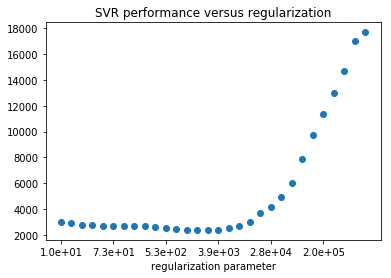

In [37]:
np.set_printoptions(precision=2)
fig3 = plt.figure()
plt.plot(mem_score_svr, 'o')
plt.title("SVR performance versus regularization")
plt.xticks(np.arange(30)[::5], ["%.1e" % C for C in Cs[::5]])
plt.xlabel("regularization parameter")
plt.show()

In [38]:
clf_svr = SVR()
l = np.argmin(mem_score_svr)
clf_svr.set_params(C=Cs[l])
clf_svr.fit(X_train_sel_lasso, y_train)
pred_error_svr = MSE(clf_svr.predict(X_test_sel_lasso), y_test)

In [39]:
print("Récapitulatif des scores:\n")

for method, error in zip(["ols           ", "pca_before_ols", "forward       ",
                          "ridge         ", "lasso         ", "ls_lasso      ",
                          "svr           "],
                         [pred_error0, pred_error1, pred_error_forward,
                          pred_error_ridge, pred_error_lasso, pred_error_LSLASSO,
                          pred_error_svr]):
    print(method + " : %.2f" % error)

Récapitulatif des scores:

ols            : 4178.05
pca_before_ols : 3591.96
forward        : 3404.80
ridge          : 3598.56
lasso          : 3184.74
ls_lasso       : 3342.18
svr            : 7091.33


Il se peut que la méthode non-linéaire vous livre de mauvais résultats. C'est le cas sur ce notebook (attention à bien conserver la graine d'initialisation). Ceci est du à un surapprentissage (overfitting), qui est un problème usuel à l'utilisation de méthodes fléxibles (non-paramétriques). En particulier, la différence de grandeur entre le risque sur le train et le risque sur le test est caractéristique du surapprentissage.

---